In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
#import seaborn as sns
import plotly
%matplotlib inline

In [2]:
val = pd.read_csv("/ecosystem-embedding/training/valid_clustered_vf.csv")
test = pd.read_csv("/ecosystem-embedding/training/test_clustered_vf.csv")

In [3]:
geoDatav = gpd.read_file('https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/US-counties.geojson')

In [4]:
preds_path = "/network/projects/_groups/ecosystem-embeddings/ebird_checkpoints/resnet18_location_env_400_epochs/preds"

In [5]:
path = "/network/projects/_groups/ecosystem-embeddings/data/hotspot_data/hotspots_june_filtered.csv"
df = pd.read_csv(path)
df = df.drop_duplicates("hotspot_id")

geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)   
gdf["split"] = ""
idx = gdf[gdf["hotspot_id"].isin(list(val["hotspot"]))].index
gdf.loc[idx,"split"] = "val"
idx = gdf[gdf["hotspot_id"].isin(list(test["hotspot"]))].index
gdf.loc[idx,"split"] = "test"

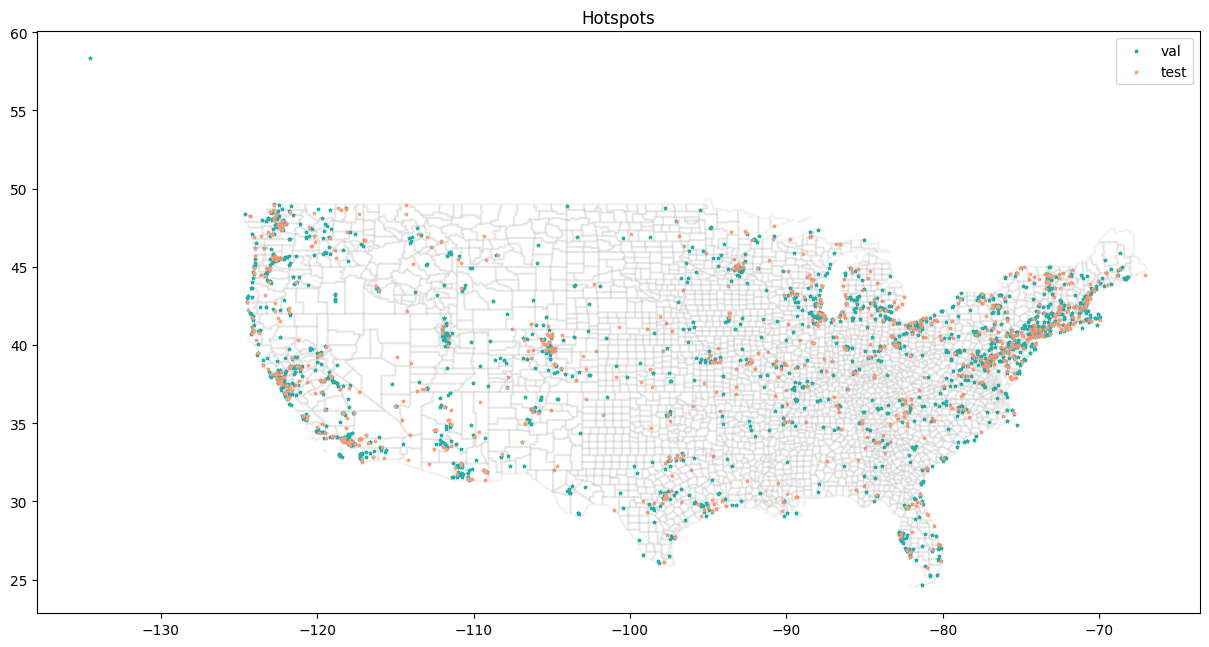

In [6]:
fig, ax = plt.subplots(figsize =(15,10))
#train_gdf.drop_duplicates(["geometry"]).boundary.plot(ax = ax, alpha = 0.4, edgecolor = "gray")
geoDatav[~geoDatav["STATE"].isin([ "02","15", "72"])].boundary.plot(ax=ax, alpha = 0.1, edgecolor = "gray" )
#gdf[gdf["split"]=="train"].plot(ax=ax,marker='*', color='yellowgreen', markersize=5, label = "train")
gdf[gdf["split"]=="val"].plot(ax=ax, marker='*', color='lightseagreen', markersize=5, label = "val")
gdf[gdf["split"]=="test"].plot(ax=ax, marker='*', color='lightsalmon', markersize=5, label = "test")

plt.legend()
plt.title("Hotspots")
plt.show()


In [6]:
test_hotspots = test["hotspot"].values
val_hotspots = val["hotspot"].values

In [7]:
preds_files =[os.path.join(preds_path, hs + ".npy") for hs in test_hotspots]

In [8]:
# format predictions as n_samples * features
preds_array = np.zeros((len(preds_files), 379))
preds_array_correct = np.zeros((len(preds_files), 379))

In [9]:
import pickle
import numpy as np
with open("/ecosystem-embedding/training/final_range_map3.pkl",'rb') as f:
    correction_data = pickle.load(f)
not_songbird_idx = np.load("/network/projects/_groups/ecosystem-embeddings/species_splits/not_songbirds_idx.npy")
test = pd.read_csv("/ecosystem-embedding/training/test_clustered_vf.csv")
preds_path = "/network/projects/_groups/ecosystem-embeddings/ebird_checkpoints/resnet18_location_env_400_epochs/preds"


In [ ]:

for hs in test["hotspot_id"].values:
    pred = np.load(os.path.join("/network/projects/_groups/ecosystem-embeddings/ebird_checkpoints/resnet18_location_env_400_epochs/preds/",  hs+ ".npy"))
    correction = correction_data[correction_data["hotspot_id"]==hs].values[0,:-1][not_songbird_idx]
    if pred != pred * correction:
        print("mismatch")

In [10]:
hs_list = []
i = 0
for hs in test_hotspots:
    path = os.path.join(preds_path, hs + ".npy") 
    if os.path.exists(path):
        pred = np.load(path)
        hs_list += [path]
        preds_array[i, :] = pred
        correction = correction_data[correction_data["hotspot_id"]==hs].values[0,:-1][not_songbird_idx]
        preds_array_correct[i, :] = pred*correction
        i += 1

# t-SNE

In [5]:
import sklearn.manifold 

In [6]:
TSNE = sklearn.manifold.TSNE(n_components=2)

In [38]:
gts = np.zeros((len(val), 684))
for i, row in val.iterrows():
    
    with open(row["species"]) as f:
        gt = json.load(f)["probs"]
    gt = np.array(gt)>0
    gts[i,:] = gt

In [39]:
from PIL import Image
out = TSNE.fit_transform(gts)

/home/mila/t/tengmeli/.conda/envs/GLC/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/mila/t/tengmeli/.conda/envs/GLC/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [34]:
out.shape

(1672, 2)

In [57]:
np.load(val["r"][i]).shape

(1, 601, 601)

In [58]:
Image.open(val["landuse"][i]).size

(849, 602)

In [62]:
maj_landuse_val = []
for i, row in val.iterrows():
    a = np.array(Image.open(val["landuse"][i]).resize((600,600)).crop((200,200,400,400)))
    values, counts = np.unique(a, return_counts=True)
    ind = np.argmax(counts)
    maj_landuse_val += [values[ind]]

In [63]:
np.array(maj_landuse_val)*4

array([ 4, 20, 20, ..., 24,  8, 28], dtype=uint8)

In [50]:
import matplotlib as mpl
mpl.rc('image', cmap='plasma')

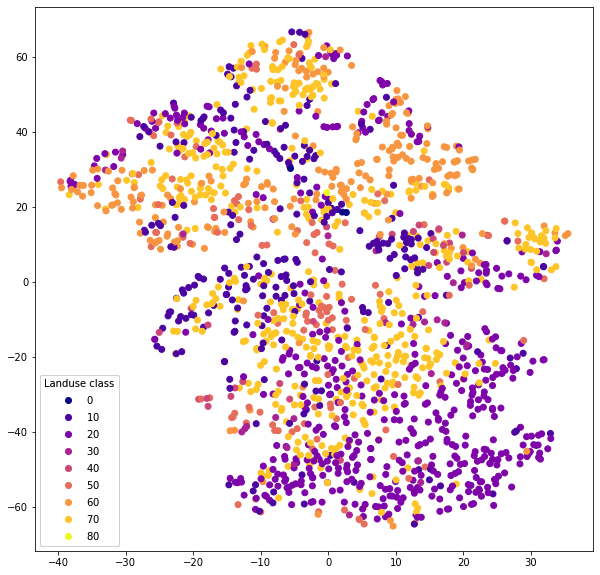

In [64]:

df1 = pd.DataFrame()
df1["comp-1"] = out[:,0]
df1["comp-2"] = out[:,1]


fig, ax = plt.subplots(figsize=(10, 10))
scatter = ax.scatter(df1["comp-1"], df1["comp-2"], c=list(np.array(maj_landuse_val)*10))

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Landuse class")
ax.add_artist(legend1)

# fit species

In [15]:
from PIL import Image

In [16]:
transpose_arr = np.transpose(preds_array_correct)

In [17]:
out_species = TSNE.fit_transform(transpose_arr)

/home/mila/t/tengmeli/.conda/envs/GLC/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/mila/t/tengmeli/.conda/envs/GLC/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [18]:
maj_landuse = []
for i, row in test.iterrows():
    a = np.array(Image.open(test["landuse"][i]))
    values, counts = np.unique(a, return_counts=True)
    ind = np.argmax(counts)
    maj_landuse += [values[ind]]

In [19]:
species = np.array(correction_data.columns)[not_songbird_idx]

In [20]:
import plotly.express as px


fig = px.scatter(
    out_species, x=0, y=1,
labels=species, color = species)



In [21]:
fig.show()

In [25]:
# create table of species per fanily

In [26]:
species_df = pd.read_csv("/ecosystem-embedding/aba_twos_and_ones.csv")

In [59]:
types = pd.read_csv("/ecosystem-embedding/ABA_Checklist_types.csv")

In [64]:
species_df.columns

Index(['TYPE', 'COMMON-NAME', 'FRENCH-NAME', 'ENGLISH-NAME', 'CODE',
       'CODE-NUMBER'],
      dtype='object')

In [66]:
species_with_type = species_df[['COMMON-NAME', 'FRENCH-NAME', 'ENGLISH-NAME', 'CODE',
       'CODE-NUMBER']].merge(types[["TYPE", "COMMON-NAME"]], how="left", left_on ="COMMON-NAME", right_on="COMMON-NAME")

In [69]:
species_with_type.to_csv("abas_twos_and_ones_type.csv")

In [71]:
species_with_type["TYPE"].nunique()

83

In [74]:
ss = pd.DataFrame({"species": species})

In [76]:
species_with_type

COMMON-NAME                FRENCH-NAME  \
0    Black-bellied Whistling-Duck  Dendrocygne à ventre noir   
1          Fulvous Whistling-Duck          Dendrocygne fauve   
2                   Emperor Goose               Oie empereur   
3                      Snow Goose             Oie des neiges   
4                    Ross's Goose                Oie de Ross   
..                            ...                        ...   
717               Painted Bunting         Passerin nonpareil   
718                    Dickcissel      Dickcissel d'Amérique   
719          Red-crested Cardinal              Paroare huppé   
720        Yellow-billed Cardinal        Paroare à bec jaune   
721                 Saffron Finch         Sicale bouton-d'or   

               ENGLISH-NAME  CODE  CODE-NUMBER  \
0    Dendrocygna autumnalis  BBWD          1.0   
1       Dendrocygna bicolor  FUWD          1.0   
2           Anser canagicus  EMGO          2.0   
3        Anser caerulescens  SNGO          1.0   
4              Anser rossii  ROGO          1.0   
..                      ...   ...          ...   
717         Passerina ciris  PABU          1.0   
718         Spiza americana  DICK          1.0   
719       Paroaria coronata  RCCA          2.0   
720       Paroaria capitata  YBCA          2.0   
721        Sicalis flaveola  SAFI          2.0   

                                                  TYPE  
0                  Ducks,  Geese, and Swans (Anatidae)  
1                  Ducks,  Geese, and Swans (Anatidae)  
2                  Ducks,  Geese, and Swans (Anatidae)  
3                  Ducks,  Geese, and Swans (Anatidae)  
4                  Ducks,  Geese, and Swans (Anatidae)  
..                                                 ...  
717  Cardinals, Piranga Tanagers and Allies (Cardin...  
718  Cardinals, Piranga Tanagers and Allies (Cardin...  
719                   Tanagers and Allies (Thraupidae)  
720                   Tanagers and Allies (Thraupidae)  
721                   Tanagers and Allies (Thraupidae)  

[722 rows x 6 columns]

In [80]:
species_interest = species_with_type.merge(ss, how="right", left_on="ENGLISH-NAME",right_on="species")

In [97]:
dic = {}
unique = species_interest["TYPE"].unique()
for i in range(len(species_interest["TYPE"].unique())):
    dic[unique[i]] = i

In [99]:
species_interest["TYPE_NUMBER"]=0

In [94]:
N=species_interest["TYPE"].nunique()
# define the colormap
cmap = plt.cm.gist_rainbow
# extract all colors from the .jet map
cmaplist = [cmap(i*4) for i in range(N)]
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, N)


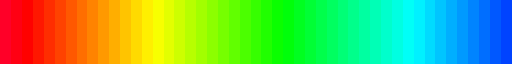

In [95]:
cmap

ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not 0                    Ducks,  Geese, and Swans (Anatidae)
1                    Ducks,  Geese, and Swans (Anatidae)
2                    Ducks,  Geese, and Swans (Anatidae)
3                    Ducks,  Geese, and Swans (Anatidae)
4                    Ducks,  Geese, and Swans (Anatidae)
                             ...                        
717    Cardinals, Piranga Tanagers and Allies (Cardin...
718    Cardinals, Piranga Tanagers and Allies (Cardin...
719                     Tanagers and Allies (Thraupidae)
720                     Tanagers and Allies (Thraupidae)
721                     Tanagers and Allies (Thraupidae)
Name: TYPE, Length: 722, dtype: object

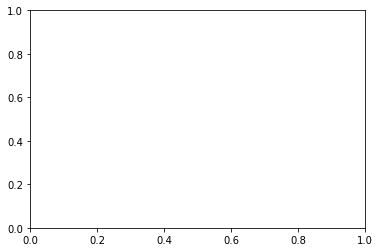

In [70]:

df3 = pd.DataFrame()
df3["comp-1"] = out_species[:,0]
df3["comp-2"] = out_species[:,1]

fig, ax = plt.subplots()
scatter = ax.scatter(df3["comp-1"], df3["comp-2"], c=species_with_type["TYPE"])

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="species cluster")
ax.add_artist(legend1)

In [15]:
out = TSNE.fit_transform(preds_array)

/home/mila/t/tengmeli/GLC-tf/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/mila/t/tengmeli/GLC-tf/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [119]:
TSNE = sklearn.manifold.TSNE(n_components=3)
out3d = TSNE.fit_transform(preds_array)

/home/mila/t/tengmeli/GLC-tf/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/mila/t/tengmeli/GLC-tf/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [11]:
from PIL import Image

In [12]:
maj_landuse = []
for i, row in test.iterrows():
    a = np.array(Image.open(test["landuse"][i]))
    values, counts = np.unique(a, return_counts=True)
    ind = np.argmax(counts)
    maj_landuse += [values[ind]]

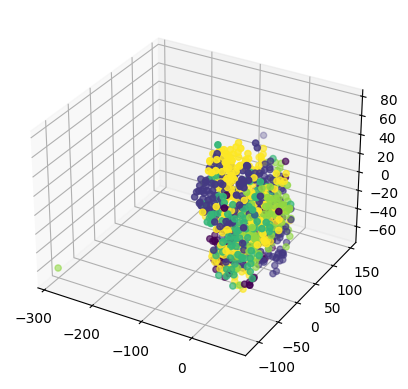

In [121]:

df2 = pd.DataFrame()
df2["comp-1"] = out3d[:,0]
df2["comp-2"] = out3d[:,1]
df2["comp-3"] = out3d[:,2]


fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(df2["comp-1"], df2["comp-2"], df2["comp-3"], c = maj_landuse)


In [20]:

df1 = pd.DataFrame()
df1["comp-1"] = out[:,0]
df1["comp-2"] = out[:,1]





fig, ax = plt.subplots()
scatter = ax.scatter(df1["comp-1"], df1["comp-2"], c=maj_landuse)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Landuse class")
ax.add_artist(legend1)


In [129]:
np.unique(maj_landuse)

array([1, 2, 3, 4, 5, 6, 7], dtype=uint8)


1. Water
Areas where water was predominantly present throughout the year; may not cover areas with sporadic or ephemeral water; contains little to no sparse vegetation, no rock outcrop nor built up features like docks; examples: rivers, ponds, lakes, oceans, flooded salt plains.

2. Trees
Any significant clustering of tall (~15 feet or higher) dense vegetation, typically with a closed or dense canopy; examples: wooded vegetation,  clusters of dense tall vegetation within savannas, plantations, swamp or mangroves (dense/tall vegetation with ephemeral water or canopy too thick to detect water underneath).

3. Grass
Open areas covered in homogenous grasses with little to no taller vegetation; wild cereals and grasses with no obvious human plotting (i.e., not a plotted field); examples: natural meadows and fields with sparse to no tree cover, open savanna with few to no trees, parks/golf courses/lawns, pastures.

4. Flooded vegetation
Areas of any type of vegetation with obvious intermixing of water throughout a majority of the year; seasonally flooded area that is a mix of grass/shrub/trees/bare ground; examples: flooded mangroves, emergent vegetation, rice paddies and other heavily irrigated and inundated agriculture.

5. Crops
Human planted/plotted cereals, grasses, and crops not at tree height; examples: corn, wheat, soy, fallow plots of structured land.

6. Scrub/shrub
Mix of small clusters of plants or single plants dispersed on a landscape that shows exposed soil or rock; scrub-filled clearings within dense forests that are clearly not taller than trees; examples: moderate to sparse cover of bushes, shrubs and tufts of grass, savannas with very sparse grasses, trees or other plants

7. Built Area
Human made structures; major road and rail networks; large homogenous impervious surfaces including parking structures, office buildings and residential housing; examples: houses, dense villages / towns / cities, paved roads, asphalt.

8. Bare ground
Areas of rock or soil with very sparse to no vegetation for the entire year; large areas of sand and deserts with no to little vegetation; examples: exposed rock or soil, desert and sand dunes, dry salt flats/pans, dried lake beds, mines.

9. Snow/Ice
Large homogenous areas of permanent snow or ice, typically only in mountain areas or highest latitudes; examples: glaciers, permanent snowpack, snow fields.
 
10. Clouds
No land cover information due to persistent cloud cover.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


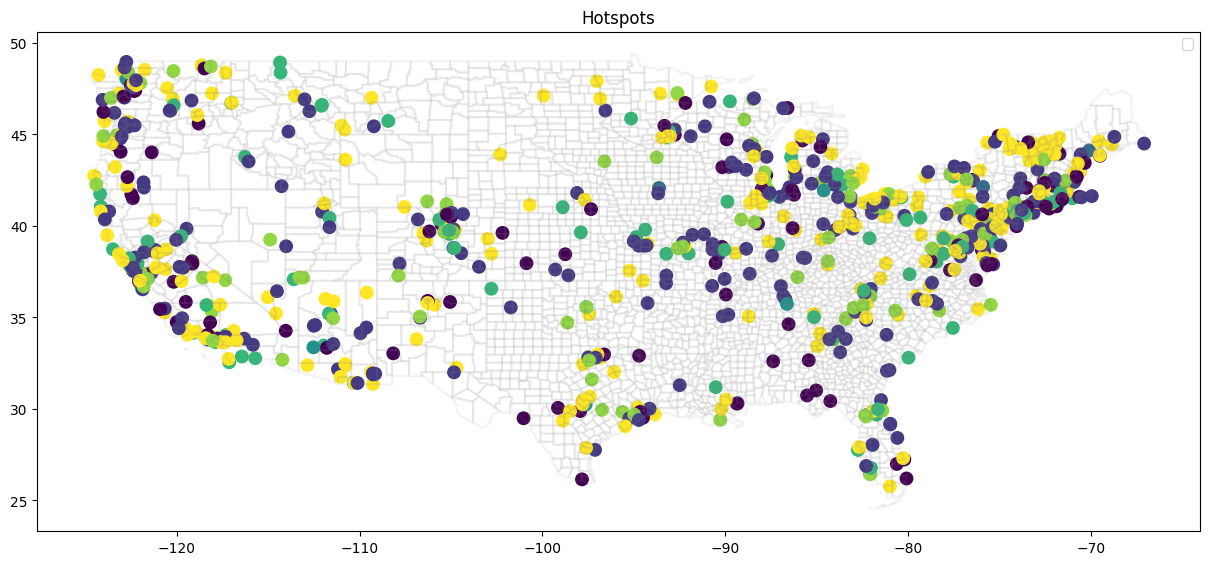

In [84]:
fig, ax = plt.subplots(figsize =(15,10))
#train_gdf.drop_duplicates(["geometry"]).boundary.plot(ax = ax, alpha = 0.4, edgecolor = "gray")
geoDatav[~geoDatav["STATE"].isin([ "02","15", "72"])].boundary.plot(ax=ax, alpha = 0.1, edgecolor = "gray" )
#gdf[gdf["split"]=="train"].plot(ax=ax,marker='*', color='yellowgreen', markersize=5, label = "train")
test_gdf.plot(ax=ax, marker='o', c=maj_landuse, markersize=80)#, label = legend1)

plt.legend()
plt.title("Hotspots")
plt.show()


In [13]:
gdf["maj_landuse"] = 0
test_gdf = gdf[gdf["split"]=="test"].copy()
test_gdf["maj_landuse"] = maj_landuse

In [17]:
with open(list(test[test["hotspot"]=="L3000499"]["species"])[0]) as f:
    aa = json.load(f)

In [23]:
a=0
for i in aa["probs"]:
    if i !=0:
        a+= 1

In [24]:
for i,row in test.iterrows():
    with open(list(test[test["hotspot"]=="L3000499"]["species"])[0]) as f:
    aa = json.load(f)

19

In [16]:
list(aa["species"])[0]

'/network/scratch/t/tengmeli/scratch/ecosystem-embedding/ebird_data_june/L3000499.json'

# analysis

In [14]:
test_df = test[['hotspot_id', "june_complete_checklists", 'rgb', "species"]]

test_gdf = gdf[gdf["split"]=="test"]

test_df["maj_landuse"] = maj_landuse

test_df = test_df.merge(test_gdf[['hotspot_id', 'lon', 'lat']])

not_songbird_idx = np.load("/network/projects/_groups/ecosystem-embeddings/species_splits/not_songbirds_idx.npy")



test_df["mae"] = 0
test_df["mse"] = 0
test_df["non_zero"] = 0
test_df["topk"] = 0
for i, row in test_df.iterrows():
    preds = np.load(preds_files[i])
    
    with open(row["species"]) as f:
        gt = json.load(f)["probs"]
    gt = np.array(gt)[not_songbird_idx]
    f.close()
    
    correction = correction_data[correction_data["hotspot_id"]==row["hotspot_id"]].values[0,:-1][not_songbird_idx]
    gt = gt * correction
    preds = preds*correction
    test_df.loc[i, "mae"] = np.sum(np.abs(preds - gt))
    test_df.loc[i, "mse"] = np.sum(np.square(preds - gt))
    nonzero = len(np.nonzero(gt)[0])
    if nonzero != 0 :
        test_df.loc[i,"non_zero"] = nonzero
    
        indices_pred = (-preds).argsort()[:nonzero]
        indices_gt = np.nonzero(gt)[0]

        test_df.loc[i,"topk"] = len([a for a in indices_pred if a in indices_gt])/nonzero
    else:
        test_df.loc[i,"topk"] = -1
    


/tmp/ipykernel_27120/3513464250.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["maj_landuse"] = maj_landuse


In [40]:
test_df.to_csv("preds_correction.csv")

In [15]:
test_df.to_csv("preds_all_correct.csv")

In [41]:
import pandas as pd

In [32]:
preds_df = pd.read_csv("preds_all_correct.csv")

In [17]:
preds_c_df = pd.read_csv("preds_correction.csv")

In [33]:
b = preds_df.loc[np.where(preds_df["topk"]<preds_c_df["topk"])[0]]

In [22]:
b["diff"] = preds_df["topk"]-preds_c_df["topk"]

In [36]:
test_df = preds_df.copy()

In [37]:
test_df["preds_"] = 7

In [38]:
test_df.loc[test_df["topk"]<0.85,"preds_"]  = 6
test_df.loc[test_df["topk"]<0.75,"preds_"]  = 5
test_df.loc[test_df["topk"]<0.65,"preds_"]  = 4
test_df.loc[test_df["topk"]<0.55,"preds_"]  = 3
test_df.loc[test_df["topk"]<0.45,"preds_"]  = 2
test_df.loc[test_df["topk"]==-1,"preds_"]  = 0
test_df.loc[test_df["topk"]==0,"preds_"]  = 1

In [40]:
test_df["preds_"]= test_df["preds_"]/7

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


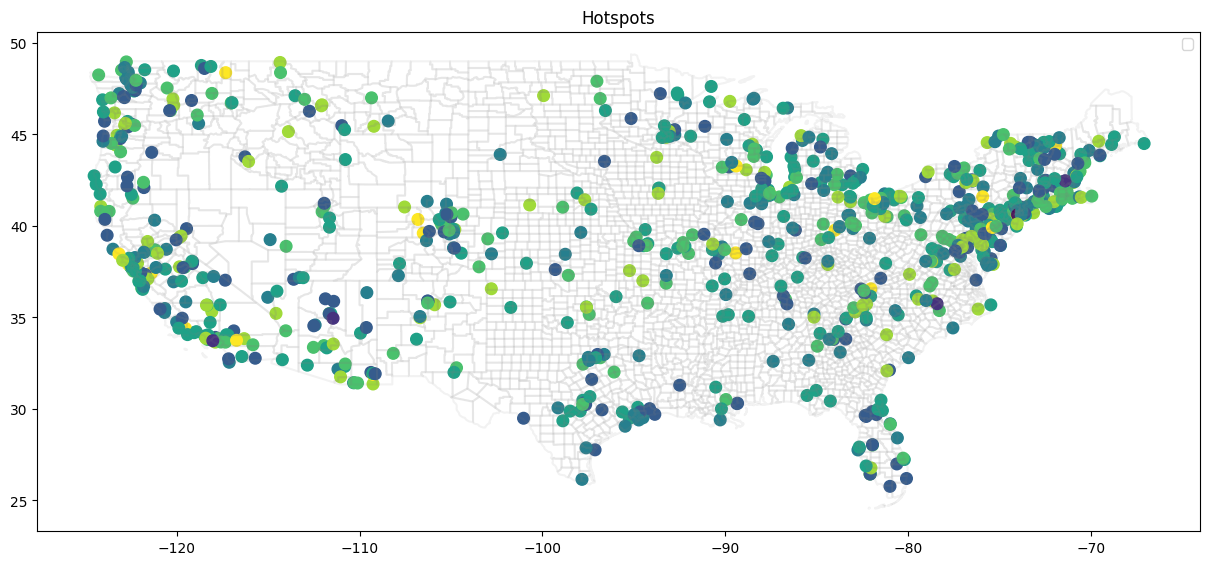

In [41]:
fig, ax = plt.subplots(figsize =(15,10))
#train_gdf.drop_duplicates(["geometry"]).boundary.plot(ax = ax, alpha = 0.4, edgecolor = "gray")
geoDatav[~geoDatav["STATE"].isin([ "02","15", "72"])].boundary.plot(ax=ax, alpha = 0.1, edgecolor = "gray" )
#gdf[gdf["split"]=="train"].plot(ax=ax,marker='*', color='yellowgreen', markersize=5, label = "train")
test_gdf.plot(ax=ax, marker='o', c=test_df["preds_"], markersize=70, legend = True)#, label = legend1)

plt.legend()
plt.title("Hotspots")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


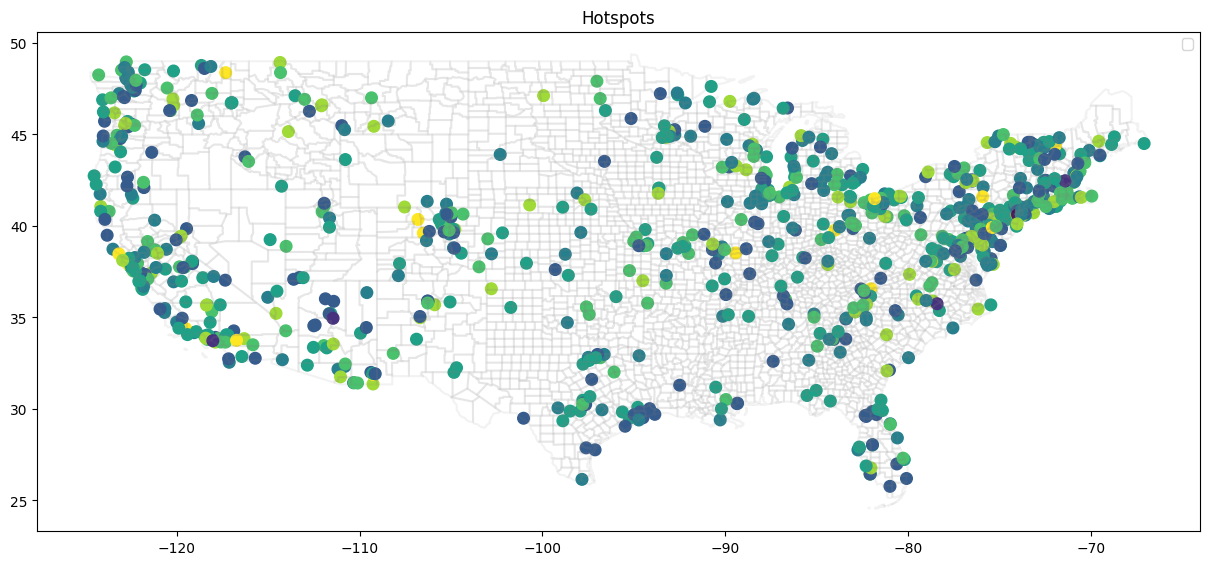

In [85]:
fig, ax = plt.subplots(figsize =(15,10))
#train_gdf.drop_duplicates(["geometry"]).boundary.plot(ax = ax, alpha = 0.4, edgecolor = "gray")
geoDatav[~geoDatav["STATE"].isin([ "02","15", "72"])].boundary.plot(ax=ax, alpha = 0.1, edgecolor = "gray" )
#gdf[gdf["split"]=="train"].plot(ax=ax,marker='*', color='yellowgreen', markersize=5, label = "train")
test_gdf.plot(ax=ax, marker='o', c=test_df["preds_"], markersize=70, legend = True)#, label = legend1)

plt.legend()
plt.title("Hotspots")
plt.show()

In [80]:
gdf[gdf["split"]=="test"].merge(test_df)

Empty GeoDataFrame
Columns: [Unnamed: 0, hotspot_id, lon, lat, county, county_code, state, state_code, june_complete_checklists, num_checklists, num_complete_checklists, num_different_species, geometry, split, maj_landuse, rgb, species, mae, mse, non_zero, topk, preds_]
Index: []

[0 rows x 22 columns]

In [83]:
gdf[gdf["split"]=="test"].merge(test_df)

Empty GeoDataFrame
Columns: [Unnamed: 0, hotspot_id, lon, lat, county, county_code, state, state_code, june_complete_checklists, num_checklists, num_complete_checklists, num_different_species, geometry, split, maj_landuse, rgb, species, mae, mse, non_zero, topk, preds_]
Index: []

[0 rows x 22 columns]

In [43]:
tt = test_gdf.merge(test_df[["hotspot_id","mae","mse", "topk", "preds_"]], left_on = "hotspot_id",right_on = "hotspot_id")

In [69]:
test_df[test_df["topk"]==0]

Unnamed: 0 hotspot_id  june_complete_checklists  \
106         106    L875038                         6   
692         692   L1268314                         5   
705         705    L304967                        12   
823         823   L3156434                         8   
827         827   L3000499                        16   

                                                   rgb  \
106  /network/scratch/t/tengmeli/scratch/ecosystem-...   
692  /network/scratch/t/tengmeli/scratch/ecosystem-...   
705  /network/scratch/t/tengmeli/scratch/ecosystem-...   
823  /network/scratch/t/tengmeli/scratch/ecosystem-...   
827  /network/scratch/t/tengmeli/scratch/ecosystem-...   

                                               species  maj_landuse  \
106  /network/scratch/t/tengmeli/scratch/ecosystem-...            6   
692  /network/scratch/t/tengmeli/scratch/ecosystem-...            2   
705  /network/scratch/t/tengmeli/scratch/ecosystem-...            6   
823  /network/scratch/t/tengmeli/scratch/ecosystem-...            6   
827  /network/scratch/t/tengmeli/scratch/ecosystem-...            6   

            lon        lat       mae       mse  non_zero  topk    preds_  
106 -100.695856  41.142823  4.501258  1.113383         7   0.0  0.142857  
692  -72.069314  42.196985  4.877285  0.941753         2   0.0  0.142857  
705 -106.280612  35.894097  2.210147  0.565650         3   0.0  0.142857  
823 -106.884399  33.804958  3.428330  0.760702        17   0.0  0.142857  
827 -120.519955  47.538802  5.262102  1.935594         5   0.0  0.142857

In [ ]:
list(test_df[test_df["topk"]==0] ["rgb"])

In [53]:

    
with open("/ecosystem-embedding/ebird_data_june/L3000499.json") as f:
    gt = json.load(f)["probs"]
gt = np.array(gt)[not_songbird_idx]
f.close()

gt[np.where(gt>0)]

In [55]:
np.where(gt>0)

(array([  8,  77, 109, 272, 331]),)

In [70]:
species = np.array(correction_data.columns)[not_songbird_idx]

In [72]:
species[[8,  77, 109, 272, 331]]

array(['Aeronautes saxatalis', 'Buteo jamaicensis', 'Cathartes aura',
       'Pandion haliaetus', 'Selasphorus calliope'], dtype=object)

In [77]:
species = np.array(correction_data.columns)[np.where(preds_array[827, :]>0.27)[0]]
species

array(['Accipiter gentilis', 'Anhinga anhinga', 'Calidris subruficollis',
       'Limosa fedoa', 'Melanitta americana'], dtype=object)

In [79]:
preds_array[827,np.where(gt>0)]

array([[0.0495606 , 0.1620221 , 0.15054408, 0.26783913, 0.01644308]])

In [80]:
preds_array[827, np.where(preds_array[827, :]>0.27)[0]]

array([0.41642663, 0.30678403, 0.28165388, 0.37308699, 0.46996319])

In [63]:
np.load('/ecosystem-embedding/satellite_data/L3000499_rgb.npy').shape

(3, 618, 618)

In [99]:
im = Image.fromarray(np.transpose(np.load('/ecosystem-embedding/satellite_data/L3000499_rgb.npy'), (1,2,0)))

In [101]:
width, height = im.size

width, height

(618, 618)

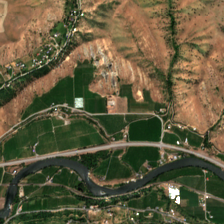

In [87]:


width, height = im.size   # Get dimensions
new_width, new_height = 224, 224
left = (width - new_width)/2
top = (height - new_height)/2
right = (width + new_width)/2
bottom = (height + new_height)/2

# Crop the center of the image
im = im.crop((left, top, right, bottom))
im

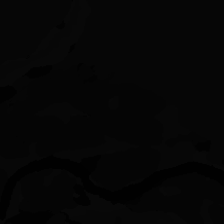

In [103]:
im = Image.open('/network/projects/ecosystem-embeddings/data/ebird_esri_lulc_planetary/ebird_esri_lulc_planetary/L3000499.tif').resize((618,618))
width, height = im.size   # Get dimensions
new_width, new_height = 224, 224
left = (width - new_width)/2
top = (height - new_height)/2
right = (width + new_width)/2
bottom = (height + new_height)/2

# Crop the center of the image
im = im.crop((left, top, right, bottom))
im

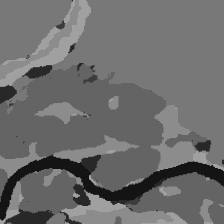

In [104]:
Image.fromarray(np.array(im)*20)

In [105]:
values, counts = np.unique(np.array(im), return_counts=True)
ind = np.argmax(counts)

In [106]:
ind

6

# Success

In [107]:
list(test_df[test_df["topk"]>0.9] ["rgb"])

['/network/scratch/t/tengmeli/scratch/ecosystem-embedding/satellite_data/L2281639_rgb.npy',
 '/network/scratch/t/tengmeli/scratch/ecosystem-embedding/satellite_data/L1102275_rgb.npy',
 '/network/scratch/t/tengmeli/scratch/ecosystem-embedding/satellite_data/L3544702_rgb.npy']

In [117]:
test_df[test_df["topk"]>0.9]

Unnamed: 0 hotspot_id  june_complete_checklists  \
131         131   L2281639                        16   
631         631   L1102275                         6   
735         735   L3544702                        48   

                                                   rgb  \
131  /network/scratch/t/tengmeli/scratch/ecosystem-...   
631  /network/scratch/t/tengmeli/scratch/ecosystem-...   
735  /network/scratch/t/tengmeli/scratch/ecosystem-...   

                                               species  maj_landuse  \
131  /network/scratch/t/tengmeli/scratch/ecosystem-...            7   
631  /network/scratch/t/tengmeli/scratch/ecosystem-...            6   
735  /network/scratch/t/tengmeli/scratch/ecosystem-...            2   

            lon        lat       mae       mse  non_zero      topk  preds_  
131 -122.447784  45.554765  3.973402  0.827583        22  0.909091     1.0  
631 -119.996131  34.740029  3.921862  1.091887        11  0.909091     1.0  
735  -79.334764  40.459247  3.665961  0.899100        20  0.950000     1.0

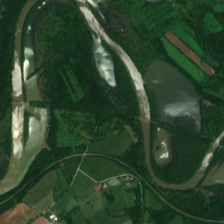

In [112]:
im = Image.fromarray(np.transpose(np.load('/ecosystem-embedding/satellite_data/L3544702_rgb.npy'), (1,2,0)))
width, height = im.size   # Get dimensions
new_width, new_height = 224, 224
left = (width - new_width)/2
top = (height - new_height)/2
right = (width + new_width)/2
bottom = (height + new_height)/2

# Crop the center of the image
im = im.crop((left, top, right, bottom))
im

In [113]:

    
with open("/ecosystem-embedding/ebird_data_june/L3544702.json") as f:
    gt = json.load(f)["probs"]
gt = np.array(gt)[not_songbird_idx]
f.close()

gt[np.where(gt>0)]

array([0.04166667, 0.04166667, 0.02083333, 0.16666667, 0.16666667,
       0.08333333, 0.14583333, 0.27083333, 0.14583333, 0.04166667,
       0.66666667, 0.29166667, 0.08333333, 0.4375    , 0.125     ,
       0.22916667, 0.0625    , 0.04166667, 0.33333333, 0.22916667])

In [114]:
indices = np.where(gt>0)

In [138]:
species = np.array(correction_data.columns)[not_songbird_idx][[  3,  12,  23,  40,  42,  64,  77,  85, 109, 114, 120, 132, 135,
        158, 160, 161, 199, 239, 245, 378]]
species

array(['Actitis macularius', 'Aix sponsa', 'Anas platyrhynchos',
       'Archilochus colubris', 'Ardea herodias', 'Branta canadensis',
       'Buteo jamaicensis', 'Butorides virescens', 'Cathartes aura',
       'Chaetura pelagica', 'Charadrius vociferus', 'Coccyzus americanus',
       'Colaptes auratus', 'Dryobates pubescens', 'Dryobates villosus',
       'Dryocopus pileatus', 'Haliaeetus leucocephalus',
       'Megaceryle alcyon', 'Melanerpes carolinus', 'Zenaida macroura'],
      dtype=object)

In [126]:
path = os.path.join(preds_path, "L3544702"+ ".npy") 
pred = np.load(path)

In [ ]:
np.where(preds_array[735, :]>0.10

In [130]:
np.where(gt>0)

(array([  3,  12,  23,  40,  42,  64,  77,  85, 109, 114, 120, 132, 135,
        158, 160, 161, 199, 239, 245, 378]),)

In [146]:
pred[np.where(pred > 0.07)[0]]

array([0.16524427, 0.15077248, 0.20310377, 0.2949042 , 0.3214269 ,
       0.09107912, 0.15811923, 0.23642167, 0.2056957 , 0.07096022,
       0.32446566, 0.18357174, 0.17313232, 0.5162968 , 0.1568195 ,
       0.3886108 , 0.09024777, 0.34031975, 0.73219645, 0.4531721 ],
      dtype=float32)

In [145]:
 np.array(correction_data.columns)[not_songbird_idx][np.where(pred > 0.07)[0]]


array(['Aix sponsa', 'Anas platyrhynchos', 'Archilochus colubris',
       'Ardea herodias', 'Branta canadensis', 'Buteo jamaicensis',
       'Butorides virescens', 'Cathartes aura', 'Chaetura pelagica',
       'Charadrius vociferus', 'Coccyzus americanus', 'Colaptes auratus',
       'Coragyps atratus', 'Dryobates pubescens', 'Dryobates villosus',
       'Dryocopus pileatus', 'Haliaeetus leucocephalus',
       'Megaceryle alcyon', 'Melanerpes carolinus', 'Zenaida macroura'],
      dtype=object)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


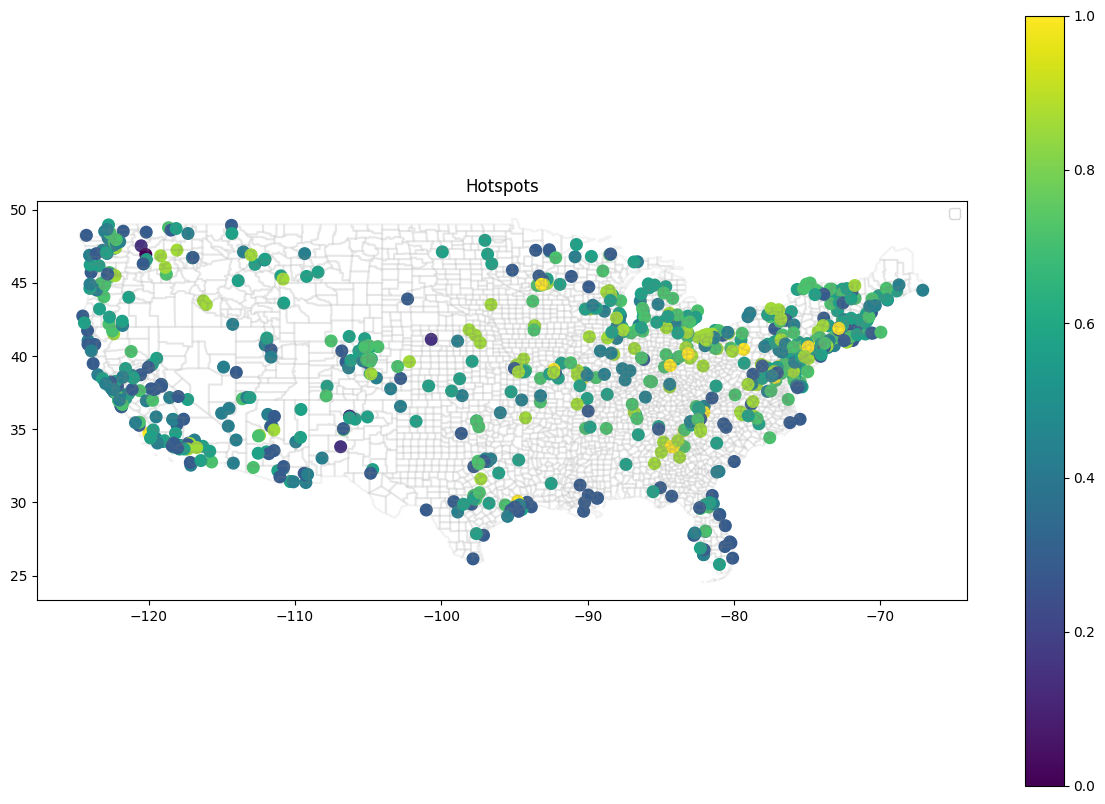

In [44]:
fig, ax = plt.subplots(figsize =(15,10))
#train_gdf.drop_duplicates(["geometry"]).boundary.plot(ax = ax, alpha = 0.4, edgecolor = "gray")
geoDatav[~geoDatav["STATE"].isin([ "02","15", "72"])].boundary.plot(ax=ax, alpha = 0.1, edgecolor = "gray" )
#gdf[gdf["split"]=="train"].plot(ax=ax,marker='*', color='yellowgreen', markersize=5, label = "train")
tt.plot(ax=ax, column ="preds_", marker='o', c=tt["preds_"], markersize=70, legend= True)

plt.legend()
plt.title("Hotspots")
plt.show()

<AxesSubplot:>

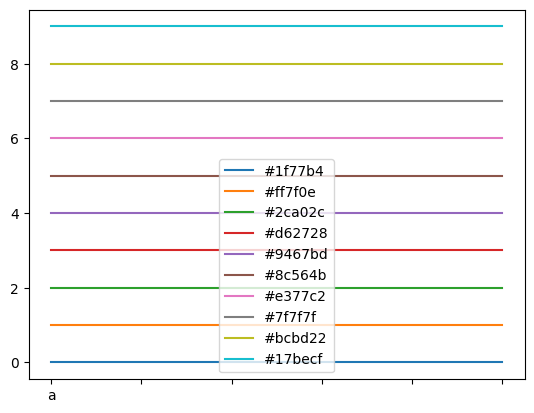

In [94]:
import matplotlib.pyplot as plt
pd.DataFrame(columns=plt.rcParams['axes.prop_cycle'].by_key()['color']).T.assign(a=range(10),b=range(10)).T.plot()
